# Plot spider


In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

from local_python.general_utils import load_pd_from_json, select_and_sort_dataframe
from local_python.radar_chart import radar_factory

In [2]:
metric_name = "f1_macro"
aggregating_functions = ["mean", "std", "count"]
metric_file_root_path = "../runs/"

dataset_configs = {
    "PlantDoc-": "PlantDoc",  #
    "PAD_UFES_20-": "PAD-UFES-20",  #
    "DDI-": "DDI",  #
    "HAM10000-": "HAM10000",  #
    "Fitzpatrick17k-": "Fitzpatrick17k",  #
    "Cassava-": "Cassava",  #
    "PlantVillage-": "PlantVillage",  #
    "PlantDataset-": "PlantDataset",  #
}

name_map = {
    "Random": "Random",
    "ImageNet_1k_SL_WinKawaks": "ImageNet SL",
    "ImageNet_1k_SL_V1": "ImageNet SL",
    "ImageNet_1k_SSL_Dino": "ImageNet SSL",
    "ImageNet_1k_SSL_SimCLR": "ImageNet SSL",
    "ImageNet_AugReg": "ImageNet AR",
    "Derma": "Derma SSL",
    "Derma_SSL_SimCLR": "Derma SSL",
    "PDDD": "Plant SL",
    "Plant": "Plant SSL",
}

In [3]:
def number_to_string(value):
    if str(value) != "nan" and value != value and value is not None:
        return str(int(value))
    else:  # NaN
        return "All"


def get_downstream(value):
    return get_feature_identifier_part(value, 0).replace("_", "-")


def get_architecture(value):
    return get_feature_identifier_part(value, 1)


def get_pretraining(value):
    return name_map[get_feature_identifier_part(value, 2)]


def get_feature_identifier_part(value, idx):
    return os.path.splitext(os.path.basename(value))[0].split("-")[idx]


def get_classifier(value):
    if value == "lr":
        return "lin."
    elif value == "knn":
        return "k-NN"
    else:
        return value


def score_to_percent_string(values):
    (mean, std, count) = values
    mean_str = "%.1f" % (100 * mean)
    std_err_str = "%.1f" % (100 * std / np.sqrt(count))
    return f"{mean_str}±{std_err_str}"


def aggregate_and_save(metric_file_path, csv_path):
    df_full = load_pd_from_json(metric_file_path)
    assert 1 == len(df_full["number_of_samples"].unique())
    df_full["Architecture"] = df_full["feature_identifier"].apply(get_architecture)
    assert 1 == len(df_full["Architecture"].unique())
    df_full["number_of_samples"] = df_full["number_of_samples"].apply(number_to_string)
    df_full["Downstream"] = df_full["feature_identifier"].apply(get_downstream)
    df_full["Downstream"] = pd.Categorical(
        df_full["Downstream"],
        [
            col
            for col in [
                "DDI",
                "PAD-UFES-20",
                "HAM10000",
                "Fitzpatrick17k",
                "PlantDoc",
                "PlantDataset",
                "Cassava",
                "PlantVillage",
            ]
            if col in df_full["Downstream"].unique()
        ],
    )
    df_full["Pre-training"] = df_full["feature_identifier"].apply(get_pretraining)
    df_full["Pre-training"] = pd.Categorical(
        df_full["Pre-training"],
        [
            col
            for col in [
                "Random",
                "ImageNet SL",
                "ImageNet SSL",
                "ImageNet AR",
                "Derma SSL",
                "Plant SL",
                "Plant SSL",
            ]
            if col in df_full["Pre-training"].unique()
        ],
    )
    df_full["Classifier"] = df_full["model_name"].apply(get_classifier)
    df_groups = df_full.groupby(["Pre-training", "Classifier", "Downstream"]).agg(
        {metric_name: aggregating_functions}
    )
    df = (
        df_groups[metric_name][aggregating_functions]
        .apply(score_to_percent_string, axis=1)
        .unstack(level=-1)
        .unstack(level=-1)
    )
    df.to_csv(csv_path)
    return df

In [4]:
df_full = aggregate_and_save(
    "../runs/master-metrics-resnet-derma.txt", "../results/f1_scores_resnet_derma.csv"
)
df_full = aggregate_and_save(
    "../runs/master-metrics-resnet-plant.txt", "../results/f1_scores_resnet_plant.csv"
)
df_full = aggregate_and_save(
    "../runs/master-metrics-vit-derma.txt", "../results/f1_scores_vit_derma.csv"
)
df_full = aggregate_and_save(
    "../runs/master-metrics-vit-plant.txt", "../results/f1_scores_vit_plant.csv"
)

Read 400 entries from master-metrics-resnet-derma.txt
Read 400 entries from master-metrics-resnet-plant.txt
Read 480 entries from master-metrics-vit-derma.txt
Read 480 entries from master-metrics-vit-plant.txt


In [5]:
def load_and_add_data(metric_file_paths, selection_config, labels):
    data = []
    for metric_file_path in metric_file_paths:
        df_full = load_pd_from_json(metric_file_path)
        df_full["number_of_samples"] = df_full["number_of_samples"].apply(
            number_to_string
        )
        target_columns = [k for k, v in selection_config.items() if v is None]
        assert 1 == len(
            target_columns
        ), f"Invalid configuration. Exactly 1 key should have (None) as value, but there are {len(target_columns)}"
        group_columns = [
            k for k in selection_config.keys() if not k == target_columns[0]
        ]
        for column, dataset_key in enumerate(dataset_configs):
            dataset_label = dataset_configs[dataset_key]
            copied_df = df_full[
                df_full["feature_identifier"].str.contains(dataset_key)
            ].copy()
            if 0 == len(copied_df):
                print(f"dataset_key: {dataset_key}, {metric_file_path}")
                continue
            return_value = select_and_sort_dataframe(copied_df, selection_config)
            selected_values = (
                return_value.groupby(group_columns)[target_columns].mean().values
            )
            if len(labels) != len(selected_values):
                print(
                    f"Number of values do not match {len(labels)} != {len(selected_values)}"
                )
                assert False
            else:
                data.append(selected_values)
    if 0 < len(data):
        columns = dataset_configs.values()
        values = np.transpose(data).reshape((-1, len(columns)))
        df_agg = pd.DataFrame(values, columns=columns)
        df_agg.index = labels
        return df_agg
    else:
        print(f"No data")
        return None

In [6]:
selection_config = {"f1_macro": None, "model_name": "dc"}
df_plot_1 = load_and_add_data(
    ["../runs/master-metrics-baseline.txt"], selection_config, labels=["Baseline"]
)
df_plot_1

Read 880 entries from master-metrics-baseline.txt


,PlantDoc,PAD-UFES-20,DDI,HAM10000,Fitzpatrick17k,Cassava,PlantVillage,PlantDataset
Baseline,0.002874,0.089431,0.426087,0.107246,0.281094,0.152315,0.004851,0.017886


In [8]:
labels = [
    "Random",
    "SL ImageNet",
    "SSL ImageNet",
    "SSL Derma",
    "SL Plant",
]
selection_config = {
    "model_name": "knn",
    "number_of_samples": "All",
    "feature_identifier": [
        "-Random",
        "-ImageNet_1k_SL_V1",
        "-ImageNet_1k_SL_WinKawaks",
        "-ImageNet_1k_SSL",
        "-ImageNet_1k_SSL_SimCLR",
        "-Derma",
        "-PDDD",
        "-Plant",
    ],  # also used as order
    "f1_macro": None,
}

df_plot_2 = load_and_add_data(
    [
        "../runs/master-metrics-resnet-derma.txt",
        "../runs/master-metrics-resnet-plant.txt",
    ],
    selection_config,
    labels=[f"knn - resnet - {label}" for label in labels],
)

labels = [
    "Random",
    "SL ImageNet",
    "SSL ImageNet",
    "SSL Derma",
    "SSL Plant",
]
df_plot_3 = load_and_add_data(
    [
        "../runs/master-metrics-vit-derma.txt",
        "../runs/master-metrics-vit-plant.txt",
    ],
    selection_config,
    labels=[f"knn - vit - {label}" for label in labels],
)

Read 400 entries from master-metrics-resnet-derma.txt
dataset_key: PlantDoc-, ../runs/master-metrics-resnet-derma.txt
dataset_key: Cassava-, ../runs/master-metrics-resnet-derma.txt
dataset_key: PlantVillage-, ../runs/master-metrics-resnet-derma.txt
dataset_key: PlantDataset-, ../runs/master-metrics-resnet-derma.txt
Read 400 entries from master-metrics-resnet-plant.txt
dataset_key: PAD_UFES_20-, ../runs/master-metrics-resnet-plant.txt
dataset_key: DDI-, ../runs/master-metrics-resnet-plant.txt
dataset_key: HAM10000-, ../runs/master-metrics-resnet-plant.txt
dataset_key: Fitzpatrick17k-, ../runs/master-metrics-resnet-plant.txt
Read 480 entries from master-metrics-vit-derma.txt
dataset_key: PlantDoc-, ../runs/master-metrics-vit-derma.txt
dataset_key: Cassava-, ../runs/master-metrics-vit-derma.txt
dataset_key: PlantVillage-, ../runs/master-metrics-vit-derma.txt
dataset_key: PlantDataset-, ../runs/master-metrics-vit-derma.txt
Read 480 entries from master-metrics-vit-plant.txt
dataset_key: PAD

In [9]:
labels = [
    "Random",
    "SL ImageNet",
    "SSL ImageNet",
    "SSL Derma",
    "SL Plant",
]

selection_config["model_name"] = "lr"

df_plot_4 = load_and_add_data(
    [
        "../runs/master-metrics-resnet-derma.txt",
        "../runs/master-metrics-resnet-plant.txt",
    ],
    selection_config,
    labels=[f"lr - resnet - {label}" for label in labels],
)
labels = [
    "Random",
    "SL ImageNet",
    "SSL ImageNet",
    "SSL Derma",
    "SSL Plant",
]
df_plot_5 = load_and_add_data(
    [
        "../runs/master-metrics-vit-derma.txt",
        "../runs/master-metrics-vit-plant.txt",
    ],
    selection_config,
    labels=[f"lr - vit - {label}" for label in labels],
)

Read 400 entries from master-metrics-resnet-derma.txt
dataset_key: PlantDoc-, ../runs/master-metrics-resnet-derma.txt
dataset_key: Cassava-, ../runs/master-metrics-resnet-derma.txt
dataset_key: PlantVillage-, ../runs/master-metrics-resnet-derma.txt
dataset_key: PlantDataset-, ../runs/master-metrics-resnet-derma.txt
Read 400 entries from master-metrics-resnet-plant.txt
dataset_key: PAD_UFES_20-, ../runs/master-metrics-resnet-plant.txt
dataset_key: DDI-, ../runs/master-metrics-resnet-plant.txt
dataset_key: HAM10000-, ../runs/master-metrics-resnet-plant.txt
dataset_key: Fitzpatrick17k-, ../runs/master-metrics-resnet-plant.txt
Read 480 entries from master-metrics-vit-derma.txt
dataset_key: PlantDoc-, ../runs/master-metrics-vit-derma.txt
dataset_key: Cassava-, ../runs/master-metrics-vit-derma.txt
dataset_key: PlantVillage-, ../runs/master-metrics-vit-derma.txt
dataset_key: PlantDataset-, ../runs/master-metrics-vit-derma.txt
Read 480 entries from master-metrics-vit-plant.txt
dataset_key: PAD

In [13]:
title = f"Resnet50 and ViT"
df_plot_l = pd.concat(
    [
        df_plot_1,
        df_plot_2,
        df_plot_3,
    ]
)
df_plot_r = pd.concat(
    [
        df_plot_1,
        df_plot_4,
        df_plot_5,
    ]
)

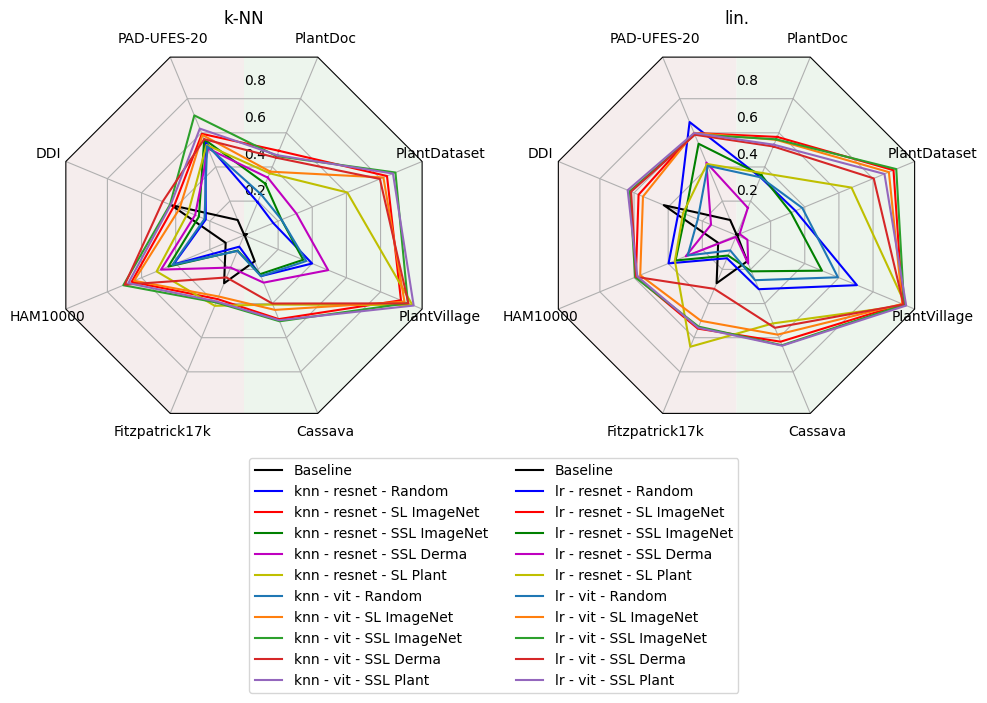

In [18]:
colors = ["black", "b", "r", "g", "m", "y"]

number_of_categories = len(df_plot_l.columns)
rotation_offset = np.pi / 2 - np.pi / number_of_categories
theta = radar_factory(
    number_of_categories, frame="polygon", rotation_offset=rotation_offset
)

fig, axes = plt.subplots(
    figsize=(10, 5),
    nrows=1,
    ncols=2,
    subplot_kw=dict(projection="radar"),
    squeeze=False,
)

ax = axes.flat[0]
for i, (index, row) in enumerate(df_plot_l.iterrows()):
    color = colors[i] if i < len(colors) else None
    ax.set_theta_offset(rotation_offset)
    ax.plot(theta, row.values, color=color, label=index)
    # ax.fill(theta, row.values, facecolor=color, alpha=0.15) # , label="_nolegend_"

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title("k-NN")
ax.set_varlabels(df_plot_l.columns)
# ax.legend(df_plot_l.index.values, loc=(0.9, 0.95), labelspacing=0.1, fontsize="small")
north = np.pi / 2 - rotation_offset
ax.axvspan(north, np.pi + north, facecolor=(0.95, 0.9, 0.9), alpha=0.7)  # red
ax.axvspan(
    np.pi + north, 2 * np.pi + north, facecolor=(0.9, 0.95, 0.9), alpha=0.7
)  # green

ax = axes.flat[1]
for i, (index, row) in enumerate(df_plot_r.iterrows()):
    color = colors[i] if i < len(colors) else None
    ax.set_theta_offset(rotation_offset)
    ax.plot(theta, row.values, color=color, label=index)
    # ax.fill(theta, row.values, facecolor=color, alpha=0.15) # , label="_nolegend_"

ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title("lin.")
ax.set_varlabels(df_plot_r.columns)
# ax.legend(df_plot_r.index.values, loc=(0.9, 0.95), labelspacing=0.1, fontsize="small")
north = np.pi / 2 - rotation_offset
ax.axvspan(north, np.pi + north, facecolor=(0.95, 0.9, 0.9), alpha=0.7)  # red
ax.axvspan(
    np.pi + north, 2 * np.pi + north, facecolor=(0.9, 0.95, 0.9), alpha=0.7
)  # green

lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.tight_layout()
# fig.legend(lines, labels, loc='lower center', ncol=4)
fig.legend(
    # lines, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=2,
)

# plt.legend(loc=(0.9, 0.8))
postfix = title.lower().replace(" ", "_") + ".png"
plt.savefig(f"../images/spider_{postfix}", bbox_inches="tight")